# QC in imscreenpy

This notebook illustrates the usage of imscreenpy for QC on the image and cell level

In [1]:
## import necessary libraries for plotting and data handling
import os
import sqlite3

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

## import the imscreenpy functions
from imscreenpy.db_df_processing.db_functions import get_image_df
from imscreenpy.config import Config
from imscreenpy.db_df_processing import db_functions
from imscreenpy.visualization.qc_plotting import image_qc_plot
from imscreenpy.qc import qc_functions
from imscreenpy.qc.qc_config import QCconfig

In [2]:
## fluorophores of interest for the example data
fluorophores_of_interest = ['APC', 'GFP', 'DNA']
target_plates = [2121039, 2121040]
### set up config, it requires a path to a config folder. Defaults that we used in our work are provided within the package source files, so we load from there here.
config = Config('../src/imscreenpy/config_files/', cfg_prefix='aml_')
config.set_intensity_columns(fluorophores_of_interest, intensity_column_suffix='')
config.db_im_table_name = 'Per_Image'
config.db_cell_table_name = 'Per_Object'

### paths to databases that contain image-level and cell-level data
plate_db_paths = ['../example_data/{}_db.db'.format(target_plates[0]), '../example_data/{}_db.db'.format(target_plates[1])]

## collect image-level dataframes for image-level QC and visualization
im_dfs = []
for in_path in plate_db_paths:
    conn = sqlite3.connect(in_path)
    print(type, conn)
    im_df = get_image_df(conn, fluorophores_of_interest)
    im_dfs.append(im_df)

<class 'type'> <sqlite3.Connection object at 0x000002079C4FC040>
<class 'type'> <sqlite3.Connection object at 0x000002079C31FE20>


In [3]:
## perform qc and get dastaframes that contain wells to exclude
im_outlier_dfs = []
for im_df in im_dfs:
    im_outlier_df = qc_functions.get_image_df_outlier_wells(im_df, fluorophores_of_interest, qc_plot_savename=None, plot_qc=False, be_relaxed=True, ignore_cellnumbers=True)
    im_outlier_dfs.append(im_outlier_df)

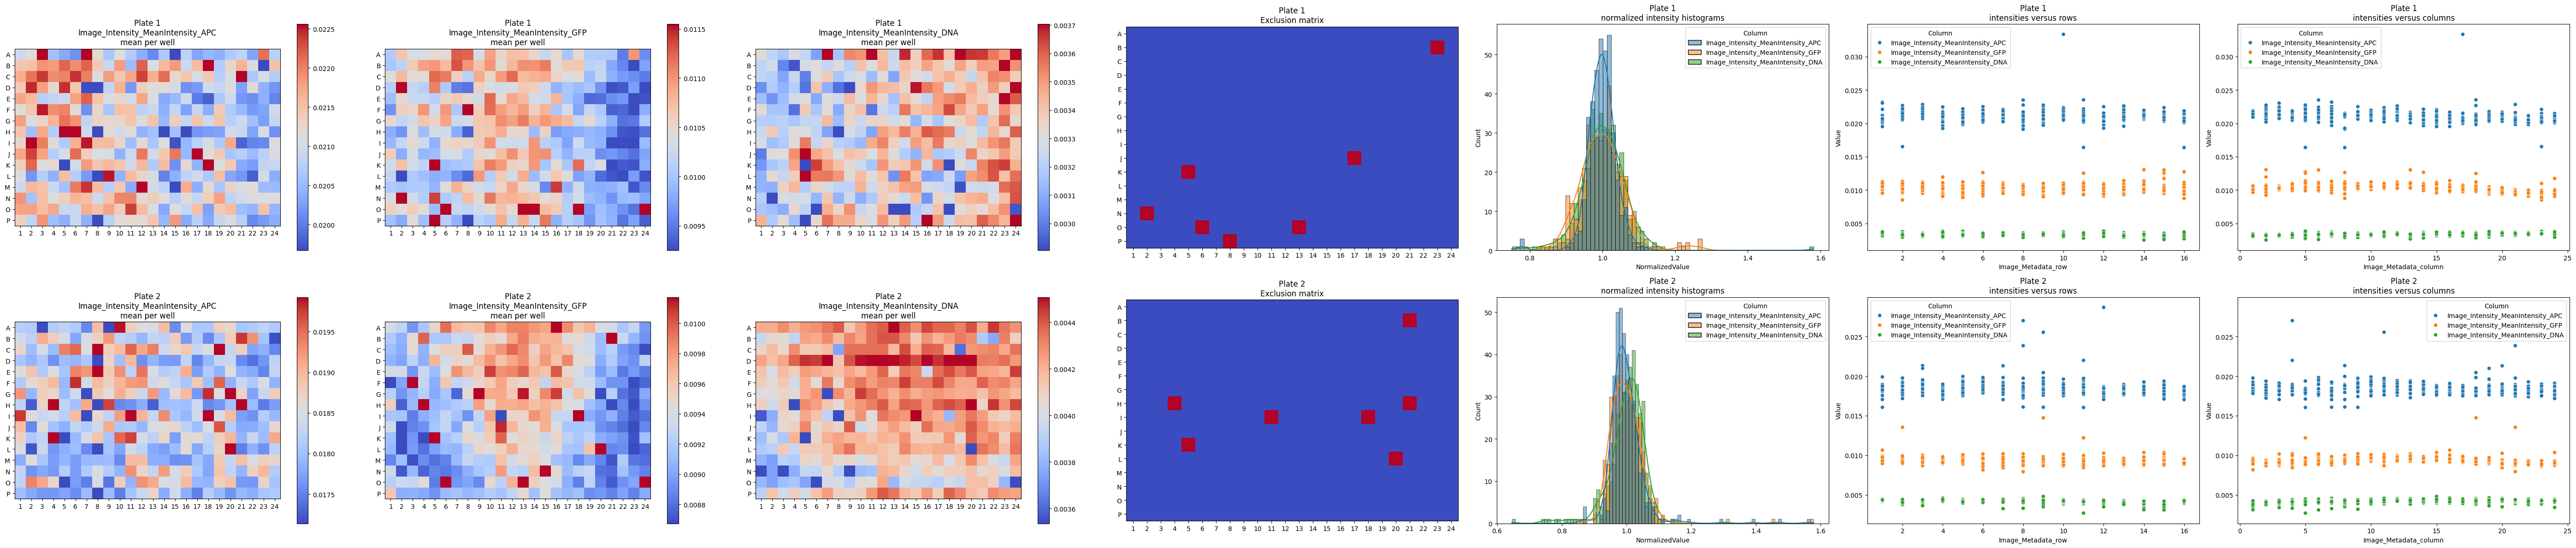

In [4]:
## make a qc plot
target_intensity_columns_image_qc = ['Image_Intensity_MeanIntensity_{}'.format(fluorophore) for fluorophore in fluorophores_of_interest]
image_qc_plot(im_dfs, target_intensity_columns_image_qc, 'im_qc_testplot_horizontal.png',\
                   platenames=None, other_qc_columns=None, well_column='Image_Metadata_Well', \
                   row_column='Image_Metadata_row', col_column='Image_Metadata_column', aggregation_strategy='mean', plot_orientation='horizontal', exclusion_matrix_to_plot=im_outlier_dfs)

## Interpreting QC plots from imscreenpy for image-based screenings 

This QC plot shows us several properties of this experiment.

First, we do have slight plate effects for all channels as we can see on the plate histograms in the first three columns.

Second, we see above that the QC excludes 7 wells in both plates. Note that histograms in the first three columns are range-normalized and capped, so we do not see these outliers there, but they do show on the histograms that depict the value distributions shown in the fifth column.

Third, the scatterplots per row and column in the last two columns in the plots above indicate that our plate effects are not particularly strong. There do not seem to be significant differences between intensities of different rows or columns. Therefore, we do not perform any plate effect normalization here.

Next up, we move on to morphology-based QC.

In [5]:
## load the single-cell datframes
sc_dfs = []
for i, in_path in enumerate(plate_db_paths):
    conn = sqlite3.connect(in_path)
    sc_df = db_functions.full_df_from_conn(conn, config.db_cell_table_name, exclusion_wells=im_outlier_dfs[i]['Image_Metadata_Well'].unique(), column_subset=config.get_all_set_columns())
    sc_dfs.append(sc_df)

We use QC based on distinct morphological properties that viable blood cells are unlikely to have. The list of properties that we used is below. All of these properties are conjugated with a logical AND in our setup. The corresponding code is in `qc_functions.py`


    nuclei_AreaShape_Area < 400
    nuclei_AreaShape_Area > 70
    nuclei_Intensity_MedianIntensity_DNA > np.finfo(np.float32).eps
    nuclei_AreaShape_Solidity > 0.85
    nuclei_AreaShape_Eccentricity < 0.75
    nuclei_Texture_SumEntropy_DNA_3_00_256 > 0.
    nuclei_Texture_Contrast_DNA_3_00_256 > 0.
    nuclei_Texture_Correlation_DNA_3_00_256 not in [-1.,1.]
    nuclei_Texture_SumAverage_DNA_3_00_256 > 0.
    nuclei_Texture_InfoMeas2_DNA_3_00_256 != 0.


In [6]:
## create a qc config object that holds our qc parameters
qc_cfg = QCconfig(config.cfg_folder, cfg_prefix=config.cfg_prefix, copy_cfg=config)

In [7]:
## get the qc vectors
qc_vectors = []
sc_dfs_postqc = []
for i, sc_df in enumerate(sc_dfs):
    qc_vector = qc_functions.make_morphology_qc_vector(sc_df, qc_cfg)
    sc_dfs_postqc.append(sc_df[qc_vector])
    print('Generated QC vector that excludes {} cells, which corresponds to {} percent'.format(int(np.sum(qc_vector == 0)), round(np.sum(qc_vector == 0) * 100 / qc_vector.shape[0], 2)))

Generated QC vector that excludes 407723 cells, which corresponds to 14.12 percent
Generated QC vector that excludes 555629 cells, which corresponds to 17.14 percent


We see that the QC excludes roughly 15% of objects for both plates. To get a better idea of whether this is reasonable we would still like to see which objects are actually being excluded, so let's visualize them.

The original data is a bit to large to load cells that have passed or failed QC directly from the raw data here, but example images are located in the `example_data` folder and we can show them here. These were generated with the script `prepare_qc_visualization.py`.

The images are shown below. The white outlines are around the nuclei, the green-ish ones are around detected cells. Red indicates the APC channel in which we have the CD34 antibody, green indicates the FITC channel in which we have the CD3 antibody and blue indicates DAPI-
Here, the first column shows cells that have passed QC and every subsequent column shows objects that did not pass QC based on an individual property which is referred to at the top of every column. Note that the white crosses mark the center of the object of the objects that the image patch is referring to.

![image info](./example_data/2121039_qc_vis.png)

As we see above, the exclusion looks reasonable. Now that we have finished the QC, we will add the treatments to the dataframe, which will allow us to compare perturbed and unperturbed states

In [8]:
## there is a so-called transferlist in the example data that contains the treatments and we have functionality in imscreenpy to add these to the dataframe
from imscreenpy import misc
#transferlist = pd.read_csv('../example_data/example_transferlist.csv', sep='\t', encoding='latin1')
transferlist = pd.read_csv('C:/Users/Ben_H/develop/develop_folder_important_parts/extract_code/annotations/drug_annotations/transferlists/20210813_transferlist.txt', sep='\t', encoding='latin1')

sc_dfs_postqc = misc.add_treatments(sc_dfs_postqc, target_plates, transferlist)

Adding treatments to 2 cell tables


Now, we can move on to adding  predictions of cell types and viabilities. There are many ways to go about this. We have used an autoencoder for this and you can check the corresponding folders in the source code `celltype_classification`, `viability_classification` and `cell_prediction_models`. We will make the repository that implements these approaches available soon and then also add a notebook that demonstrates the usage of patchpy. For simplicity and because running these predictions requires a fair amount of computational resources, we only load the celltype and viability assignments here.

For this particular sample, cells were stained with antibodies for C34 in the APC channel and CD3 in the FITC channel. Therefore, the columns that we add correspond to these celltypes and viability.

In [9]:
sc_dfs_final = []
target_populations = ['CD34', 'CD3']
columns_to_add = target_populations + ['Viable']

for i, sc_df in enumerate(sc_dfs_postqc):
    ## load dataframes that contain predictions of cell types and viabilities
    prediction_df = pd.read_csv('../example_data/{}_predictions.csv'.format(target_plates[i]))
    ## briefly check that the dataframes match. We do a very basic check on ObjectNumnber and unique_image_id, but this can be extended to more columns if needed.
    assert np.all(sc_df['ObjectNumber'].to_numpy() == prediction_df['ObjectNumber'].to_numpy()
                     ), 'ObjectNumber does not match between sc_df and prediction_df for plate {}'.format(target_plates[i])
    assert np.all(sc_df['unique_image_id'].to_numpy().astype(np.int64) == prediction_df['unique_image_id'].to_numpy().astype(np.int64)
                     ), 'unique_image_id does not match between sc_df and prediction_df for plate {}'.format(target_plates[i])
    ## now we can add the predictions to the dataframe
    pred_add_dict = dict()
    for col in columns_to_add:
        pred_add_dict[col] = prediction_df[col].values
    sc_df_final = sc_df.assign(**pred_add_dict)
    sc_dfs_final.append(sc_df_final)

We can now generate a viability dataframe from the single-cell data to evaluate differential drug responses

In [11]:
### now we can concatenate these dataframes and use them to generate a viability dataframe, ie a dataframe that only contains the numbers of viable cells per well for each celltype
from imscreenpy.db_df_processing.df_functions import full_table_to_well_viability_table

full_sc_df = pd.concat(sc_dfs_final)
viability_df = full_table_to_well_viability_table(full_sc_df, target_populations, viability_column_name='Viable')
viability_df.to_csv('../example_data/viability_df.csv', index=False)